#### Импорт библиотек

In [3]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

#### Путь для датасета

In [4]:
# Объявляем путь до каталога data, где хранится файл
PATH_TO_FILE = Path("main.ipynb").resolve().parents[1].joinpath("data")

#### Загрузка и обзор данных

In [5]:
# Загружаем файл
data = pd.read_csv(PATH_TO_FILE.joinpath("dataset.csv"))
# выводим первые 5 строк
data.head(5)

,Population,Area (sq. mi.),Pop. Density,GDP ($ per capita),Literacy (%),Infant mortality,Development Index
0,9944201,1284000,7.7,1200,47.5,93.82,2
1,5450661,43094,126.5,31100,100.0,4.56,4
2,26783383,437072,61.3,1500,40.4,50.25,2
3,9439,102,92.5,3400,97.0,7.35,4
4,3431932,176220,19.5,12800,98.0,11.95,3


In [6]:
# Получаем информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Population          225 non-null    int64  
 1   Area (sq. mi.)      225 non-null    int64  
 2   Pop. Density        225 non-null    float64
 3   GDP ($ per capita)  225 non-null    int64  
 4   Literacy (%)        225 non-null    float64
 5   Infant mortality    225 non-null    float64
 6   Development Index   225 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 12.4 KB


In [7]:
# Смотрим на распределение данных в датасете
data.describe()

,Population,Area (sq. mi.),Pop. Density,GDP ($ per capita),Literacy (%),Infant mortality,Development Index
count,2.250000e+02,2.250000e+02,225.000000,225.000000,225.000000,225.000000,225.000000
mean,2.898360e+07,6.023363e+05,380.545778,9729.333333,83.987556,35.261956,2.968889
std,1.183879e+08,1.797679e+06,1667.386671,10053.936329,19.455371,35.453113,0.883333
min,7.026000e+03,2.000000e+00,0.000000,500.000000,17.600000,0.000000,1.000000
25%,4.391170e+05,4.167000e+03,29.300000,1900.000000,76.200000,7.870000,2.000000
50%,5.042920e+06,8.660000e+04,78.800000,5600.000000,93.000000,20.970000,3.000000
75%,1.765484e+07,4.465500e+05,188.500000,15700.000000,98.500000,55.510000,4.000000
max,1.313974e+09,1.707520e+07,16271.500000,55100.000000,100.000000,191.190000,4.000000


#### Обучение модели

In [8]:
# Определяем target переменную
X = data[["Population", 'GDP ($ per capita)', 'Literacy (%)']]
y = data['Development Index']

In [9]:
# Делим данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Нормализуем данные
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Создаем и обучаем модель
model = lgb.LGBMClassifier(verbose=-1)
model.fit(X_train_scaled, y_train)

LGBMClassifier(verbose=-1)

In [12]:
# Проводим кросс-валидацию
scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f'Средняя точность кросс-валидации: {scores.mean():.3f}')

Средняя точность кросс-валидации: 0.733


In [14]:
# Прогнозируем на тестовой выборке
y_pred = model.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 на тестовых данных: {f1:.3f}')

F1 на тестовых данных: 0.700


#### Визуализируем прогнозируемые и реальные значения

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_histograms(real_values, predicted_values):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
    
    sns.histplot(real_values, ax=ax[0], kde=False)
    ax[0].set_title('Реальные значения')
    ax[0].set_xlabel('Значение')
    ax[0].set_ylabel('Частота')
    
    sns.histplot(predicted_values, ax=ax[1], kde=False)
    ax[1].set_title('Предсказанные значения')
    ax[1].set_xlabel('Значение')
    ax[1].set_ylabel('Частота')
    
    plt.tight_layout()
    plt.show()

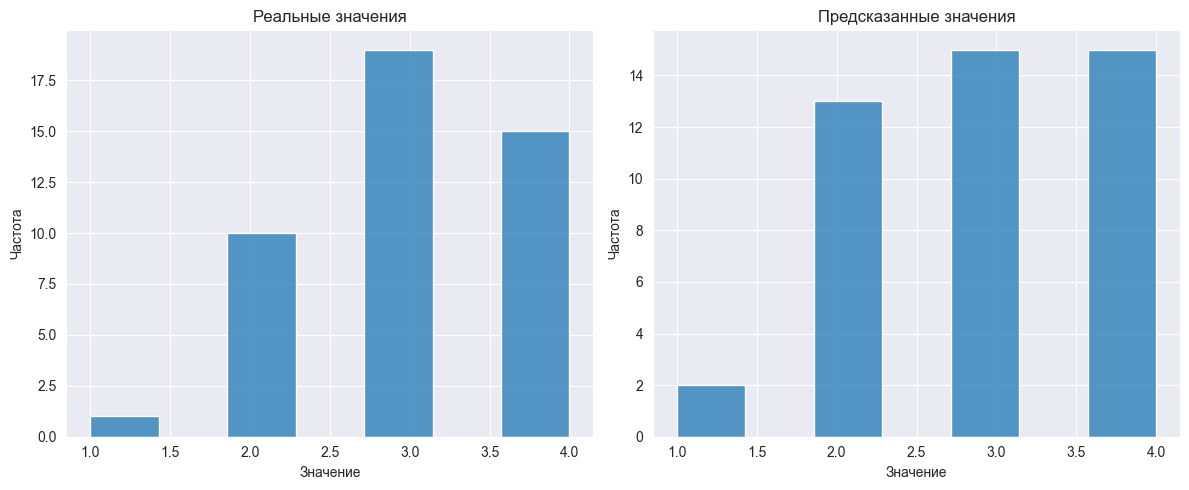

In [16]:
# Реальные значения
real_values = y_test
# Предсказанные моделью значения
predicted_values = model.predict(X_test_scaled)
# Гистограммы
visualize_histograms(real_values, predicted_values)

#### Матрица ошибок (ошибки первого и второго рода)

In [17]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    
    if class_names is None:
        class_names = set(y_test)
    
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

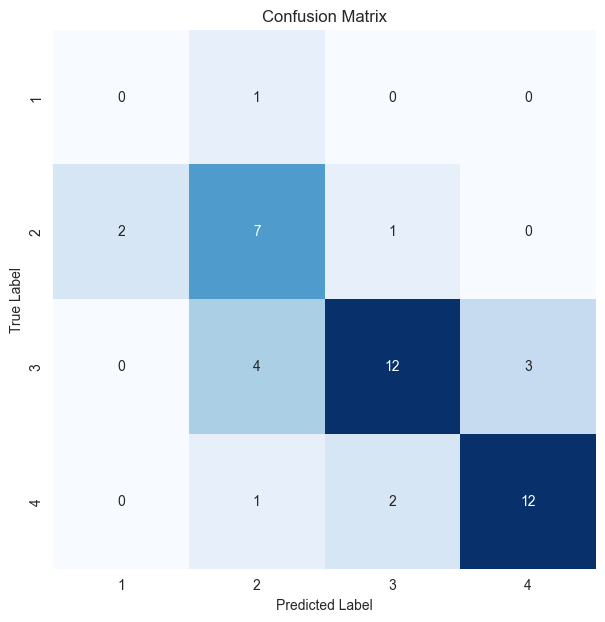

In [18]:
plot_confusion_matrix(y_test, y_pred)

#### Вывод

Цель лабораторной работы #2:
Разработка приложения для классификации объектов с использованием современных методов машинного обучения.

Для проведения исследования использовались следующие инструменты и методы:
1. Python с библиотеками Scikit-learn, Pandas, NumPy и Matplotlib для обработки данных, создания моделей и визуализации результатов.
2. Jupyter Notebook для интерактивного анализа данных и разработки моделей.
3. Наборы данных, содержащие признаки и классы объектов, требующих классификации.



In [24]:
from sklearn.metrics import classification_report

target_names = ["class_1", "class_2", "class_3", "class_4"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class_1       0.00      0.00      0.00         1
     class_2       0.54      0.70      0.61        10
     class_3       0.80      0.63      0.71        19
     class_4       0.80      0.80      0.80        15

    accuracy                           0.69        45
   macro avg       0.53      0.53      0.53        45
weighted avg       0.72      0.69      0.70        45



Как видно из таблицы, наиболее эффективно алгоритм справился с распознаванием класса 3 и 4, достигнув высоких показателей точности и полноты. Класс 1 оказался самым сложным для распознавания, что может свидетельствовать о недостаточной информативности признаков для данного класса. 

Проведённая работа позволила достичь поставленных целей и показала высокую эффективность использования современных методов машинного обучения для задачи классификации. Наиболее подходящим алгоритмом для решения поставленной задачи оказался градиентный бустинг, обеспечивающий максимальную точность при приемлемых затратах времени на обучение.